In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

from warnings import filterwarnings
filterwarnings('ignore')

In [17]:
df = pd.read_csv('Data/cleaned_data.csv')

In [18]:
df.head()

,Head,Body,Tags,First Answer,Tags Count
0,Brain Segmentation To 3D Model,my goal is to take a dataset of brain tumor se...,computer-vision python,No Answer,2
1,Active Learning regression with Random Forest,i have a dataset of about k points and i am tr...,machine-learning regression uncertainty-quanti...,No Answer,5
2,Comparing Reinforcement Learning models,i am currently completing my thesis on optimis...,reinforcement-learning policy-gradients monte-...,No Answer,4
3,"Why ""Good Model"" that performs great on holdou...",i have this binary regression model that has f...,deep-learning deep-neural-networks prediction ...,No Answer,5
4,What are Reservoir computers used for today?,reservoir computers were very popular in the e...,machine-learning recurrent-neural-networks res...,No Answer,3


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48811 entries, 0 to 48810
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Head          48811 non-null  object
 1   Body          48811 non-null  object
 2   Tags          48811 non-null  object
 3   First Answer  48811 non-null  object
 4   Tags Count    48811 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


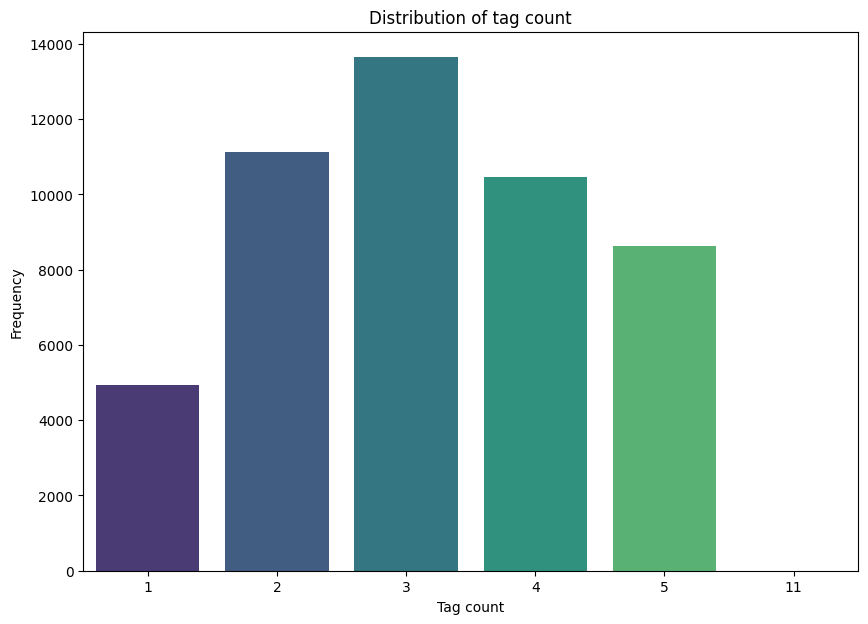

In [20]:
# plot distribution of tag count
fig = plt.figure(figsize=[10,7])
sns.countplot(data=df, x='Tags Count', color='blue',palette='viridis')
plt.title('Distribution of tag count')
plt.ylabel('Frequency')
plt.xlabel('Tag count')
plt.show()

In [21]:
# vectorize tags
tag_vectorizer = CountVectorizer(tokenizer = lambda x: str(x).split())
tag_mat = tag_vectorizer.fit_transform(df['Tags'])

In [22]:
# get names of tags
tag_names = tag_vectorizer.get_feature_names_out()
type(tag_names), len(tag_names)

(numpy.ndarray, 2693)

In [23]:
tag_names[:20]

array(['.net', '1d-convolution', '2d-convolution', '2sls',
       '3d-convolution', '3d-reconstruction', '5-star-scheme',
       '8-puzzle-problem', '8-queens-problem', 'a', 'a-star', 'a3c',
       'ab-test', 'abbreviation', 'absolute-risk', 'absolute-value',
       'academia', 'accelerometer', 'accept-reject', 'accuracy'],
      dtype=object)

In [24]:
tag_freq = tag_mat.sum(axis=0)

In [25]:
# store tag names and frequency as a pandas series
tag_freq_ser = pd.Series(tag_freq.A1, index=tag_names)
tag_freq_ser.sort_values(ascending=False, inplace=True)
tag_freq_ser.head(10)

machine-learning          8148
r                         4187
regression                3840
deep-learning             3435
neural-networks           3006
data-request              2527
python                    2503
reinforcement-learning    2348
classification            2200
time-series               2039
dtype: int64

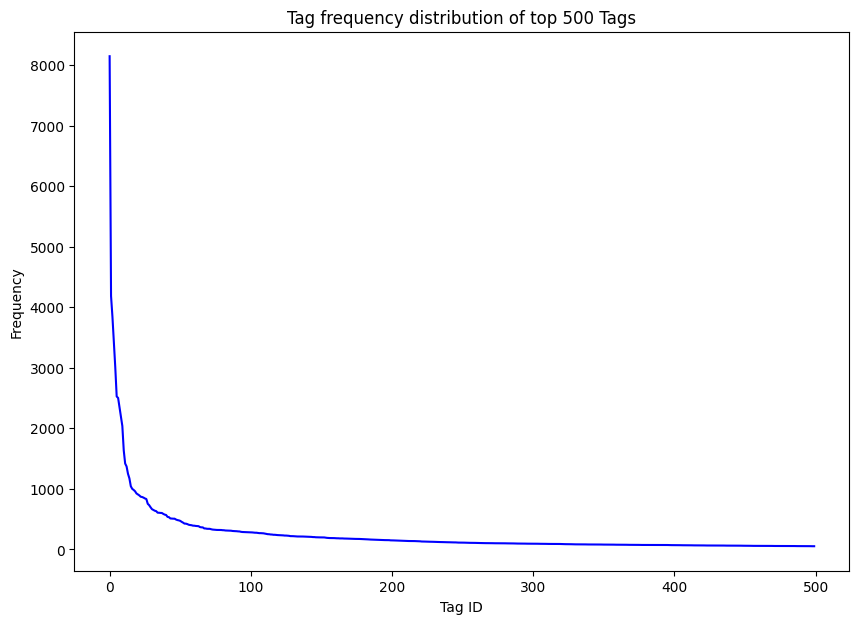

In [26]:
# plot distribution of tag frequency (top 500)
fig = plt.figure(figsize=[10,7])
plt.plot(tag_freq_ser.iloc[:500].values,c='blue')
plt.title('Tag frequency distribution of top 500 Tags')
plt.ylabel('Frequency')
plt.xlabel('Tag ID')
plt.show()

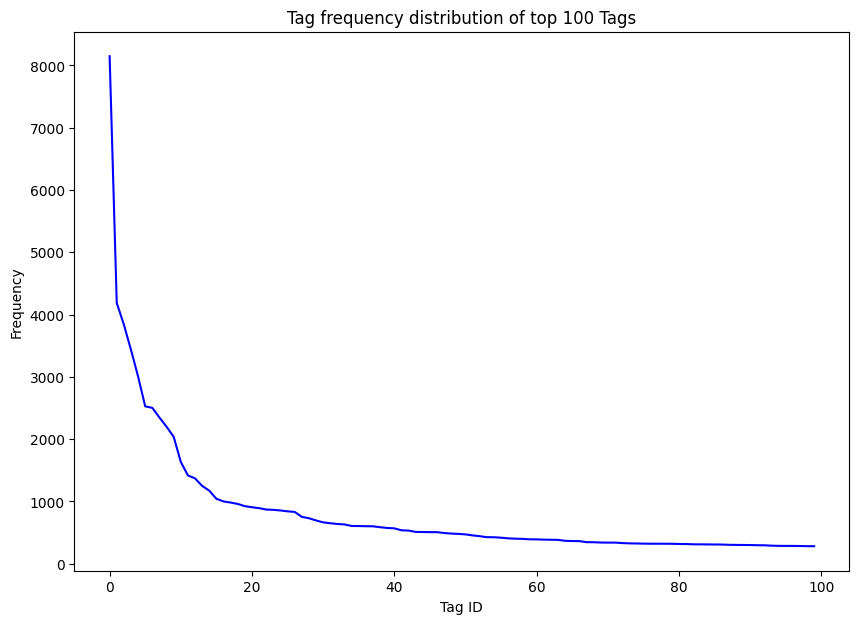

In [27]:
# plot distribution of tag frequency (top 100)
fig = plt.figure(figsize=[10, 7])
plt.plot(tag_freq_ser.iloc[:100].values, c='blue')
plt.title("Tag frequency distribution of top 100 Tags")
plt.ylabel("Frequency")
plt.xlabel("Tag ID")
plt.show()

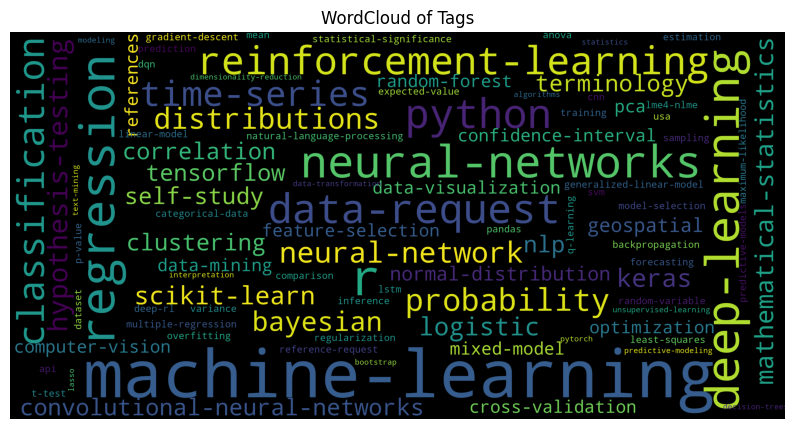

In [28]:
# plot word count for tags
wordcloud = WordCloud(
    background_color="black", max_words=200,scale=10,  
).generate_from_frequencies(tag_freq_ser)
fig = plt.figure(figsize=[10, 10])
plt.title("WordCloud of Tags")
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

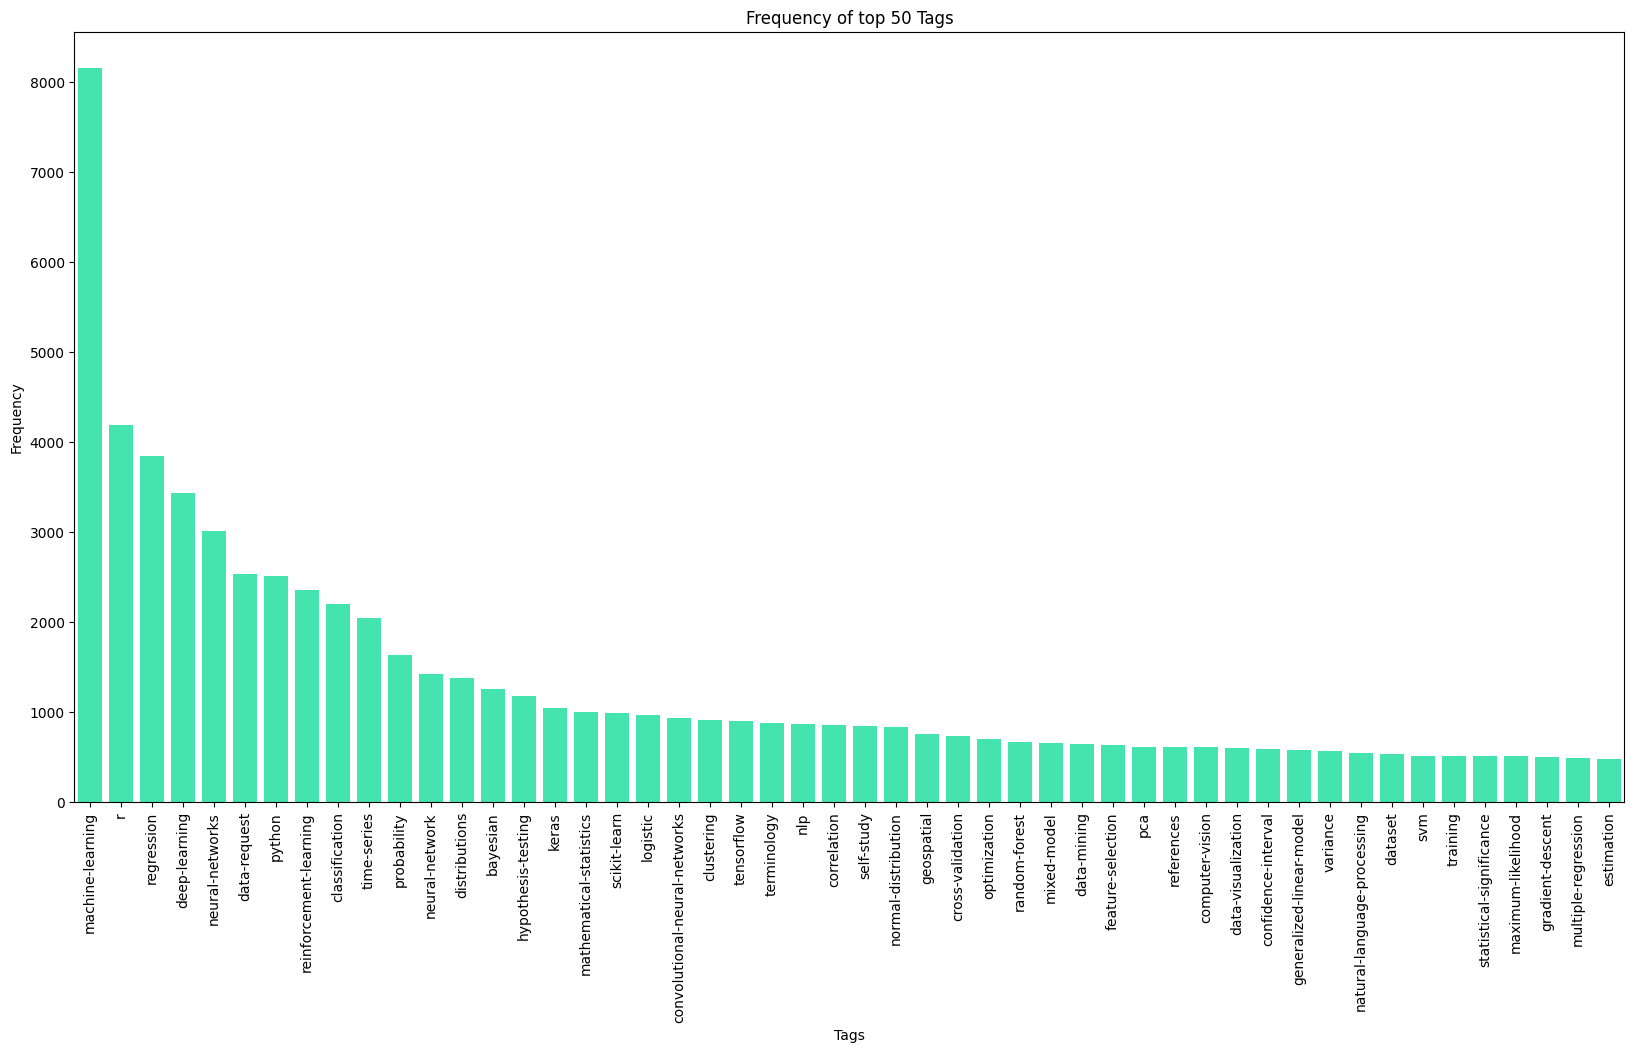

In [29]:
# Frequency top 50 tags
fig = plt.figure(figsize=[20, 10])
sns.barplot(
    x=tag_freq_ser.iloc[:50].index,
    y=tag_freq_ser.iloc[:50].values,
    color=sns.xkcd_rgb["greenish cyan"],
)
plt.title("Frequency of top 50 Tags")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [45]:
from gensim.models import word2vec
import string
import spacy
import nltk
from nltk.corpus import stopwords
nlp = spacy.load('en_core_web_lg')

In [32]:
df['Text'] = df['Head'] + ' ' + df['Body']

In [48]:
# Create a list of stopwords
stopwords_nltk = nltk.corpus.stopwords.words('english')
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS
stopwords = list(set(stopwords_nltk + list(stopwords_spacy)+list(STOPWORDS)+list(string.ascii_letters)))
print(len(stopwords))

460


In [49]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word.strip() not in stopwords])

df['Text'] = df['Text'].apply(lambda x: remove_stopwords(x))

In [50]:
# Create Word2Vec model from text column

list_of_sent = [sent.split() for sent in df['Text'].values]

w2v_model = word2vec.Word2Vec(list_of_sent, vector_size=100,window=5, min_count=2, workers=4)

# w2v_model.wv.most_similar('c')

In [57]:
w2v_model.wv.most_similar('python')

[('matlab', 0.7700817584991455),
 ('python?', 0.7150527834892273),
 ('libraries', 0.7121180891990662),
 ('packages', 0.7024398446083069),
 ('script', 0.6917449831962585),
 ('pyspark', 0.690960168838501),
 ('javascript', 0.6865161657333374),
 ('octave', 0.6727550625801086),
 ('weka', 0.6678482294082642),
 ('ruby', 0.664380669593811)]